# Тестовое задание.
# 1. Часть 1. SQL
1. Есть таблица [FactSales]: Интересующие поля - [SalesAmountFull], [SalesQuantityFull], [PartnerKey], [ProductKey], [DateKey]. Соответственно по порядку продажи в деньгах, продажи в шт, кто купил, что купил, дата.
* Задание: Посчитать ПО МЕСЯЦАМ скользящую годовую сумму продаж (и деньги и шт) в разрезе Месяц(например 202005)-[PartnerKey]-[ProductKey], т.е сколько какого товара купил контрагент суммарно за текущий и 11 предыдущих месяцев.
* PS. Данные у нас условно с 2010 года например.
* Результат - *.txt файл с SQL-кодом

# 1. Часть 2. Python & ML
2. Создать лаги продаж на период от 1 дня до 2 недель для каждого SKU из файла test_for_lags.pkl
3. Файл task_2_ содержит данные о сессиях пользователей. Одна строчка в файле содержит факторы, посчитанные по одной дневной сессии пользователя (одна строка = один пользователь). В строке факторы разделены между собой знаками табуляции, физический смысл факторов не раскрывается. Известно, что в файле присутствуют как сессии живых людей, так и роботов. Также известно, что роботные сессии отличаются от сессий живых пользователей тем, что имеют определенные закономерности в поведении (для нашего случая в значениях факторов). 
* Необходимо разделить сессии на две части - роботные и человеческие. Известно, что под каждую закономерность может попадать не более 20% сессий. Количество закономерностей (=правил) - не меньше трех. Количество факторов в каждом правиле - не менее четырех.  Один из способов решения задания (не обязательно использовать
его!): http://en.wikipedia.org/wiki/Association_rule_learning 
* Выполненное задание должно содержать *.ipynb файл с кодом , описание выбранной методики, ход мыслей, словесное описание полученных результатов, получившиеся правила (если методом был выбраны ассоциативные правила), а также разделенные на 2 части сессии - роботные и человеческие.

## 2.1. Импорты

In [69]:
from apyori import apriori
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15, 6)})

import datetime

## 2.2. Загрузка и первоначальное знакомство с данными

### 2.2.1. Файл 'test_for_lags.pkl'

In [43]:
test_for_lags = pd.read_pickle(r'E:\Dwnld\Тестовое\test_for_lags.pkl')

In [44]:
test_for_lags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308304 entries, 0 to 308303
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   DateKey     308304 non-null  datetime64[ns]
 1   ProductKey  308304 non-null  int32         
 2   sales_qnty  308304 non-null  int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 4.7 MB


In [45]:
test_for_lags.head()

,DateKey,ProductKey,sales_qnty
0,2020-02-17,694085,192
1,2020-02-21,718133,6859
2,2020-02-25,744235,2040
3,2020-05-06,777569,53
4,2020-05-16,766750,27993


In [46]:
test_for_lags.describe()

,ProductKey,sales_qnty
count,308304.000000,3.083040e+05
mean,706644.318624,1.314437e+03
std,52636.940939,3.717582e+04
min,0.000000,-2.949350e+05
25%,663821.000000,1.200000e+01
50%,697650.000000,6.000000e+01
75%,743244.000000,3.000000e+02
max,848822.000000,1.797017e+07


In [47]:
# замечено, что количество заказов где-то принимает отрицательные значения - надо посмотреть где это произошло?
test_for_lags.query('sales_qnty<0')

,DateKey,ProductKey,sales_qnty
172,2020-05-27,828045,-15
218,2020-05-14,770612,-84
248,2020-01-13,668783,-7
363,2020-06-01,826346,-3
390,2020-03-11,748634,-19
...,...,...,...
307583,2020-05-27,810730,-90
307675,2020-05-27,828106,-30
307886,2020-01-13,664242,-10
307980,2020-01-16,703013,-3


In [48]:
# таких данных довольно много - 2883 шт, не понятно что это - ошибка ввода (и надо тогда их взять по модулю), или значение этого столбца НЕ "количество заказов"
# но нам надо получить лаги, а даже такие значения - это какая-то активность, поэтому возьмем эти значение по модулю
test_for_lags['sales_qnty'] = test_for_lags['sales_qnty'].apply(abs)

### Вывод по файлу 'test_for_lags.pkl':
1. Пропусков в данных нет, формат данных корректный.
2. Поле 'sales_qnty' содержит значения меньше нуля!

In [49]:
# для того, чтобы оперировать с данными, как с временным рядом, назначим время индексом, предварительно отсортировав его
test_for_lags = test_for_lags.sort_values (by = 'DateKey', ascending = True)
test_for_lags = test_for_lags.set_index('DateKey')

In [50]:
print('Данные отсортированы по времени:', test_for_lags.index.is_monotonic)

Данные отсортированы по времени: True


In [51]:
print('Имеем данные за период:', test_for_lags.index.min(), '-', test_for_lags.index.max())

Имеем данные за период: 2020-01-01 00:00:00 - 2020-06-01 00:00:00


<AxesSubplot:title={'center':'Исходные значения'}, xlabel='Время заказа', ylabel='Количество заказов'>

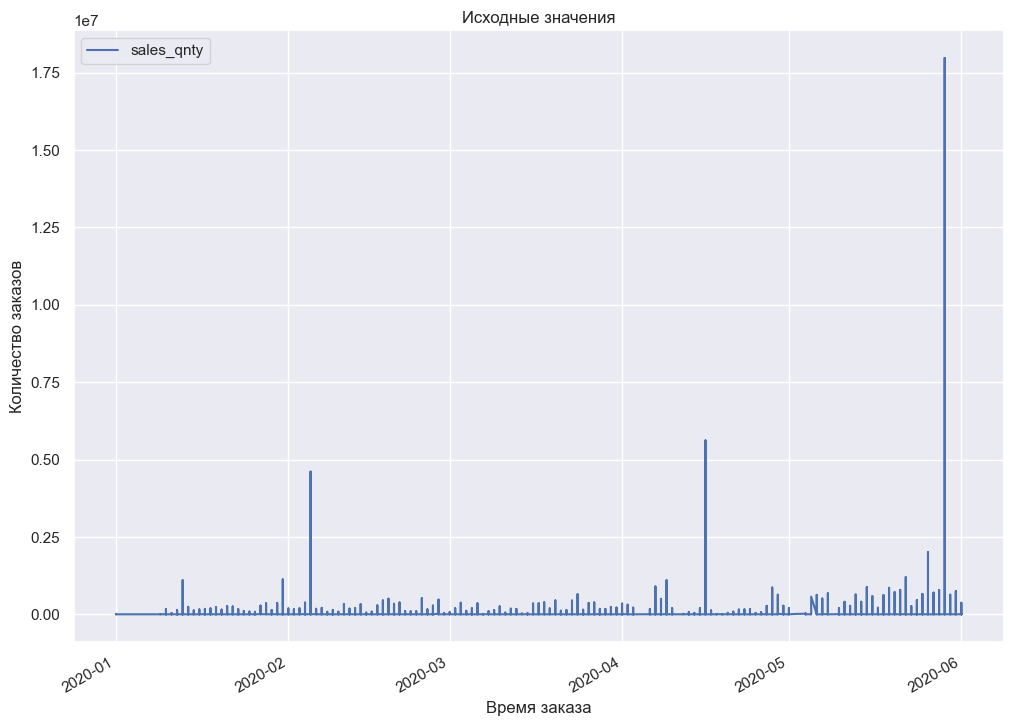

In [52]:
test_for_lags.drop('ProductKey', axis=1).plot(figsize=[12,9], title='Исходные значения', xlabel='Время заказа', ylabel='Количество заказов')

In [53]:
# т.к. надо посчитать лаги от отдного дня, то надо сделать ресемплинг количества заказов по дням
test_for_lags_1D = test_for_lags.drop('ProductKey', axis=1).resample('1D', label='right').sum()

In [54]:
test_for_lags_1D.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 2020-01-02 to 2020-06-02
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   sales_qnty  153 non-null    int64
dtypes: int64(1)
memory usage: 2.4 KB


In [55]:
test_for_lags_1D.head()

,sales_qnty
DateKey,
2020-01-02,1120
2020-01-03,0
2020-01-04,0
2020-01-05,0
2020-01-06,0


<AxesSubplot:title={'center':'Исходные значения'}, xlabel='Время заказа', ylabel='Количество заказов'>

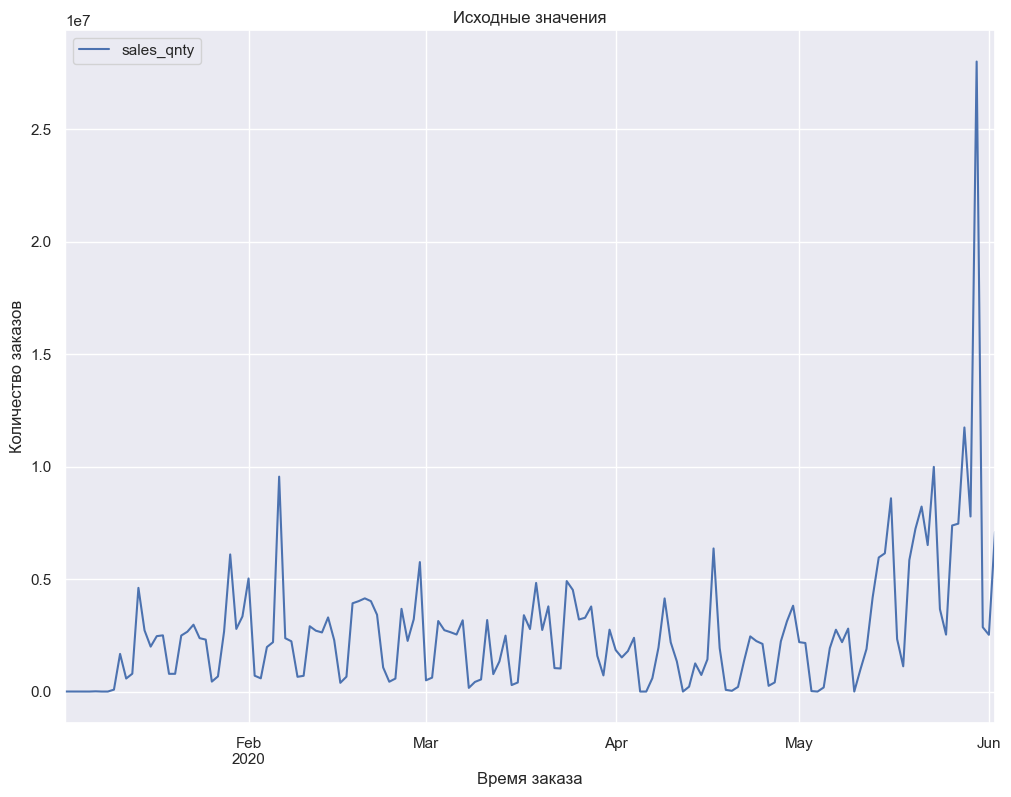

In [56]:
test_for_lags_1D.plot(figsize=[12,9], title='График заказов по дням', xlabel='Время заказа', ylabel='Количество заказов')

In [ ]:
# заказы идут не только в рабочие дни, поэтому используем именно "1D", а не "1B"

In [58]:
test_for_lags_1D.query('sales_qnty==0')

,sales_qnty
DateKey,
2020-01-03,0
2020-01-04,0
2020-01-05,0
2020-01-06,0
2020-01-08,0
2020-01-09,0
2020-04-12,0
2020-05-04,0
2020-05-10,0


In [62]:
# объединим их в слитные интервалы
day_lags = list(test_for_lags_1D.query('sales_qnty==0').index)

In [63]:
day_lags

[Timestamp('2020-01-03 00:00:00'),
 Timestamp('2020-01-04 00:00:00'),
 Timestamp('2020-01-05 00:00:00'),
 Timestamp('2020-01-06 00:00:00'),
 Timestamp('2020-01-08 00:00:00'),
 Timestamp('2020-01-09 00:00:00'),
 Timestamp('2020-04-12 00:00:00'),
 Timestamp('2020-05-04 00:00:00'),
 Timestamp('2020-05-10 00:00:00')]

In [64]:
day_lags[0] - day_lags[1]

Timedelta('-1 days +00:00:00')

In [70]:
delta_t = datetime.timedelta(days=1,
                             seconds=0,
                             microseconds=0,
                             milliseconds=0,
                             minutes=0,
                             hours=0,
                             weeks=0)

In [78]:
lag_list = []
lag_str = ''

for i in range(len(day_lags)):
    if i!=len(day_lags)-1:
        if day_lags[i+1]-day_lags[i]<=delta_t:
            print('LAG')
            if lag_str=='':
                lag_str = day_lags[i].strftime("%Y-%m-%d")
        else:
            if lag_str!='':
                lag_str = lag_str + f' - {day_lags[i].strftime("%Y-%m-%d")}'
                lag_list.append(lag_str)
                lag_str = ''
            print('-')

LAG
LAG
LAG
-
LAG
-
-
-


In [80]:
print('Обнаружены следующие лаги по продажам:')
for lag in lag_list:
    print(lag)

Обнаружены следующие лаги по продажам:
2020-01-03 - 2020-01-06
2020-01-08 - 2020-01-09


In [60]:
# теперь посмотрим лаги по 2-недельным интервалам
test_for_lags_2W = test_for_lags.drop('ProductKey', axis=1).resample('2W', label='right').sum()

<AxesSubplot:title={'center':'График заказов по неделям'}, xlabel='Время заказа', ylabel='Количество заказов'>

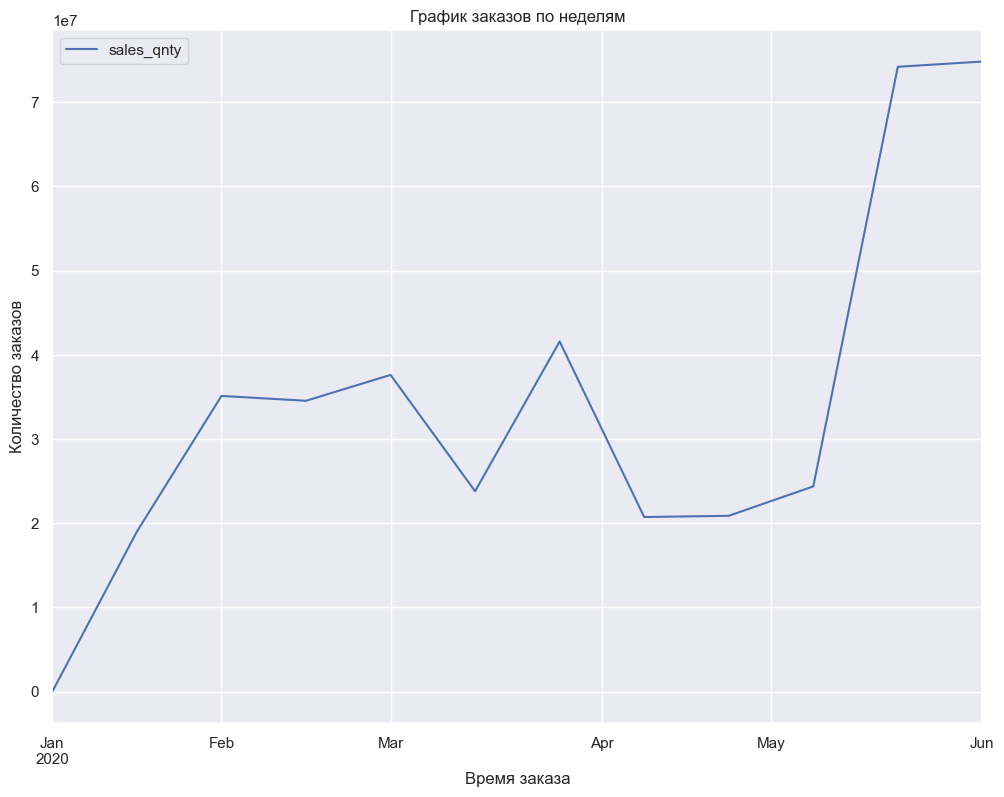

In [61]:
test_for_lags_2W.plot(figsize=[12,9], title='График заказов по 2-недельным интервалам', xlabel='Время заказа', ylabel='Количество заказов')

In [ ]:
# лагов по 2-недельным интервалам не замечено

### 2.2.2. Файл 'task2_1_'

In [6]:
names = ['session_id'] + list(np.arange(187).astype(str))

In [7]:
data = pd.read_csv(r'E:\Dwnld\Тестовое\task2_1_', sep='\t', names=names)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49958 entries, 0 to 49957
Columns: 188 entries, session_id to 186
dtypes: int64(43), object(145)
memory usage: 71.7+ MB


In [9]:
data.sample(10)

,session_id,0,1,2,3,4,5,6,7,8,...,177,178,179,180,181,182,183,184,185,186
972,0528d2577046084c33aa25e6403a3c3f,1,0,0,1377952440,246,-,67,0,0,...,0,-,-,-,-,-,-,-,-,-
33437,ab7ab576253456d842f33a3d019384f5,1,0,0,1365793977,387,118,90,0,0,...,0,-,-,-,-,-,-,-,-,273
8040,299dd1cfe4e36ea6fa671f237fe82b72,-,0,0,1399282056,0,-,16,0,0,...,0,-,-,-,-,-,-,-,-,-
38511,c536ff2a54cd9e96bd6369b4dbabb063,-,0,-,1399303393,0,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-
34578,b187fd9126ce70ebee86c23afba2125a,-,0,-,1399238094,0,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-
28575,927b686663ae25146469b48028d5e491,-,0,-,1383281973,184,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-
6870,238f1af7a325f8dd9ef81c98679630b2,1,0,0,1397109006,24,-,67,0,0,...,0,-,-,-,-,-,-,-,-,-
45466,e8ab54f7008a6b109a41e44ed901bf9b,-,0,-,1376027888,268,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-
32250,a56f950d106d44de839da5e69ef34cef,-,0,-,1399241377,0,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-
47273,f19e9361aaf02acc879091022fc52436,-,0,-,1387126800,141,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-


In [10]:
data.shape

(49958, 188)

In [11]:
data.describe()

,1,3,4,7,8,9,12,13,14,15,...,100,101,138,139,140,157,158,169,173,174
count,49958.0,4.995800e+04,49958.000000,49958.000000,49958.0,49958.0,49958.000000,4.995800e+04,49958.000000,4.995800e+04,...,49958.0,49958.0,49958.0,49958.000000,49958.000000,49958.000000,49958.0,49958.0,49958.0,49958.000000
mean,0.0,1.388501e+09,124.348773,0.001161,0.0,0.0,17425.885384,1.399274e+09,10.856560,1.399292e+09,...,0.0,0.0,0.0,14.476680,0.003123,1.200749,0.0,0.0,0.0,0.019636
std,0.0,1.789247e+07,206.954517,0.034054,0.0,0.0,23700.004339,2.443561e+04,6.753564,2.257537e+04,...,0.0,0.0,0.0,52.516905,0.128548,1.623373,0.0,0.0,0.0,0.138749
min,0.0,1.220330e+09,0.000000,0.000000,0.0,0.0,0.000000,1.399234e+09,0.000000,1.399234e+09,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
25%,0.0,1.382018e+09,0.000000,0.000000,0.0,0.0,15.000000,1.399256e+09,6.000000,1.399279e+09,...,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000
50%,0.0,1.396988e+09,26.000000,0.000000,0.0,0.0,1945.000000,1.399273e+09,10.000000,1.399297e+09,...,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000
75%,0.0,1.399265e+09,199.000000,0.000000,0.0,0.0,32192.750000,1.399295e+09,17.000000,1.399310e+09,...,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000
max,0.0,1.399320e+09,2070.000000,1.000000,0.0,0.0,86390.000000,1.399320e+09,23.000000,1.399320e+09,...,0.0,0.0,0.0,1204.000000,23.000000,62.000000,0.0,0.0,0.0,1.000000


### Вывод по файлу 'task2_1_'
1. Часть столбцов считалась как текст. Необходимо привести столбцы к формату int.
2. Все значения положительные. Пропуски можно заменить на отрицательные значения, чтобы отличать их от всех остальных.

In [12]:
# приведем данные к формату int и заменить пропуски на отрицательные значения, а слишком большие числа - на максимальные для данной системы
for n_col in tqdm(range(187)):
    data[str(n_col)] = data[str(n_col)].astype(str)
    data[str(n_col)] = np.where(data[str(n_col)]=='-', '-1', data[str(n_col)])
    data[str(n_col)] = np.where(data[str(n_col)]>str(sys.maxsize), str(sys.maxsize), data[str(n_col)])
    #data[str(n_col)] = data[str(n_col)].astype(int)
    data[str(n_col)] = data[str(n_col)].apply(lambda x: int(x))

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:15<00:00, 12.34it/s]


In [13]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
count,49958.000000,49958.0,49958.000000,4.995800e+04,4.995800e+04,4.995800e+04,4.995800e+04,49958.000000,49958.0,49958.0,...,49958.000000,4.995800e+04,4.995800e+04,4.995800e+04,49958.000000,4.995800e+04,49958.000000,4.995800e+04,4.995800e+04,49958.000000
mean,10.064454,0.0,-0.587233,1.388501e+09,1.181584e+17,2.566253e+16,2.640102e+16,0.001161,0.0,0.0,...,-0.583770,9.231126e+14,2.400093e+15,3.692450e+14,-0.208675,8.861881e+15,-0.699127,1.846225e+14,1.846225e+14,38.337443
std,130.689610,0.0,0.602544,1.789247e+07,1.037246e+18,4.858407e+17,4.927619e+17,0.034054,0.0,0.0,...,1.528983,9.226879e+16,1.487670e+17,5.835766e+16,6.082056,2.857613e+17,37.638749,4.126551e+16,4.126551e+16,128.437821
min,-1.000000,0.0,-1.000000,1.220330e+09,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000,0.0,0.0,...,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000
25%,-1.000000,0.0,-1.000000,1.382018e+09,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000,0.0,0.0,...,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000
50%,-1.000000,0.0,-1.000000,1.396988e+09,2.600000e+01,-1.000000e+00,-1.000000e+00,0.000000,0.0,0.0,...,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000
75%,1.000000,0.0,0.000000,1.399265e+09,2.170000e+02,-1.000000e+00,1.600000e+01,0.000000,0.0,0.0,...,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000
max,1648.000000,0.0,11.000000,1.399320e+09,9.223372e+18,9.223372e+18,9.223372e+18,1.000000,0.0,0.0,...,261.000000,9.223372e+18,9.223372e+18,9.223372e+18,100.000000,9.223372e+18,6676.000000,9.223372e+18,9.223372e+18,741.000000


In [100]:
vect = data.drop('session_id', axis=1).to_numpy()

In [101]:
vect.shape

(49958, 187)

In [102]:
vect

array([[ 2,  0,  0, ..., -1, -1,  0],
       [-1,  0, -1, ..., -1, -1, -1],
       [-1,  0, -1, ..., -1, -1, -1],
       ...,
       [-1,  0, -1, ..., -1, -1, -1],
       [ 1,  0,  0, ..., -1, -1, -1],
       [ 1,  0,  0, ..., -1, -1, -1]], dtype=int64)

In [103]:
#from sklearn.cluster import AgglomerativeClustering

In [104]:
#model = AgglomerativeClustering(n_clusters=2)

In [ ]:
#clustering = model.fit(vect)

In [ ]:
#clustering

In [7]:
#test_for_lags['DateKey'] = pd.to_datetime(test_for_lags['DateKey'])

In [15]:
with open(r'F:\Desktop\DS\IEC\Тестовое\task2_1_', newline='') as csvfile:
    # читаем первую строку
    dialect = csv.Sniffer().sniff(csvfile.read())
    # во избежании потерь данных
    # переводим курсор на начало файла
    csvfile.seek(0)
    # получаем объект чтения
    reader = csv.reader(csvfile, dialect)
    # ... обрабатываем содержимое CSV файла ...

In [13]:
import csv

dialect = csv.Sniffer()

In [16]:
reader

In [ ]:
from apyori import apriori

# Load the dataset
dataset = pd.read_csv('path/to/dataset.csv', header=None)

# Convert the dataset to a list of lists
records = []
for i in range(len(dataset)):
    records.append([str(dataset.values[i,j]) for j in range(len(dataset.columns))])

# Run the Apriori algorithm
association_rules = apriori(records, min_support=0.005, min_confidence=0.2, min_lift=3, min_length=2)

# Print the association rules
for rule in association_rules:
    print(rule)

In [14]:
dataset = data.drop('session_id', axis=1)

In [ ]:
# Convert the dataset to a list of lists
records = []
for i in range(len(dataset)):
    records.append([str(dataset.values[i,j]) for j in range(len(dataset.columns))])

# Run the Apriori algorithm
association_rules = apriori(records, min_support=0.005, min_confidence=0.2, min_lift=3, min_length=2)

# Print the association rules
# for rule in association_rules:
#    print(rule)

In [2]:
!pip install apyori

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5955 sha256=e3934b410c6b6ea60c52c6e847ec599e98ee8012183f95d3fad5f6efd8adb3cc
  Stored in directory: c:\users\e.yumagulov\appdata\local\pip\cache\wheels\32\2a\54\10c595515f385f3726642b10c60bf788029e8f3a1323e3913a
Successfully built apyori



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
